In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import torchvision
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms


In [2]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
train_dataset = FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 306kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.51MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 3.84MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
print(train_dataset.data.shape)

torch.Size([60000, 28, 28])


In [7]:
class ANNClassificationCustomClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.w1 = torch.randn(784,512, requires_grad=True, device = device)
        self.b1 = torch.randn(512, requires_grad= True, device = device)

        self.w2 = torch.randn(512,384, requires_grad=True, device = device)
        self.b2 = torch.randn(384, requires_grad= True, device = device)

        self.w3 = torch.randn(384, 256, requires_grad=True, device = device)
        self.b3 = torch.randn(256, requires_grad= True, device = device)

        self.w4 = torch.randn(256,128, requires_grad=True, device = device)
        self.b4 = torch.randn(128, requires_grad= True, device = device)

        self.w5 = torch.randn(128,10, requires_grad=True, device = device)
        self.b5 = torch.randn(10, requires_grad= True, device = device)

    def forward(self, x):
        x = self.flatten(x)

        hiddenLayer1 = torch.relu(torch.matmul(x, self.w1)+ self.b1)
        hiddenLayer2 = torch.relu(torch.matmul(hiddenLayer1, self.w2)+ self.b2)
        hiddenLayer3 = torch.relu(torch.matmul(hiddenLayer2, self.w3)+ self.b3)
        hiddenLayer4 = torch.relu(torch.matmul(hiddenLayer3, self.w4)+ self.b4)

        output = torch.matmul(hiddenLayer4, self.w5)+ self.b5

        return output

    def parameters(self):
        return [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3,
                self.w4, self.b4, self.w5, self.b5]

In [8]:
def trainModel(model, optimizer, criterion, epochs):
    train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True)

    losses = []

    for ephoch in range(epochs):
        for x_batch, y_batch in train_loader:
            model.train()
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            losses.append(loss)
    return model, losses

In [9]:
def testModel(model):
    test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = True)

    y_true = []
    ypred = []
    model.eval()

    with torch.no_grad():
      for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)
        y_predCpu = y_pred.cpu().detach().numpy()
        y_predCpu = np.argmax(y_predCpu, axis=1)
        y_batchCpu = y_batch.cpu().detach().numpy()
        y_true.append(y_batchCpu)
        ypred.append(y_predCpu)
    return y_true, ypred

In [10]:
model = ANNClassificationCustomClass()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model, losses = trainModel(model, optimizer, criterion, epochs = 100)

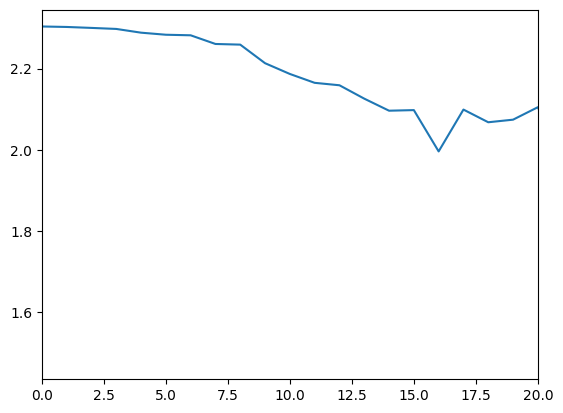

In [ ]:
cpuLoss = []
for loss in losses:
  loss = loss.cpu().detach().numpy()
  cpuLoss.append(loss)
plt.plot(cpuLoss)
plt.xlim(0,20)
plt.show()

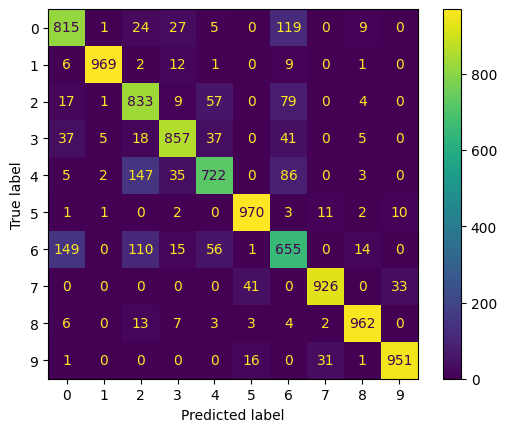

In [11]:
y_true, y_pred = testModel(model)
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
cm = confusion_matrix(y_true, y_pred)
cd = ConfusionMatrixDisplay(cm,display_labels= np.arange(10))
cd.plot()

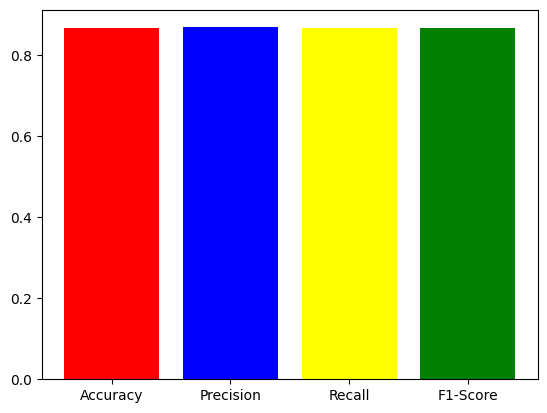

In [12]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average = 'macro')
recall = recall_score(y_true, y_pred, average = 'macro')
f1 = f1_score(y_true, y_pred, average = 'macro')
plt.bar(["Accuracy", "Precision", "Recall", "F1-Score"], [accuracy,precision,recall,f1], color = ['red','blue','yellow', 'green'])
plt.show()

In [13]:
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Accuracy:  0.866
Precision:  0.8681359453595631
Recall:  0.866
F1:  0.8662820281949786
